In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import sklearn
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from src.db_structure import DB_DIR
from src.db_utils import ThingDB

plt.rcParams['figure.figsize'] = [10, 10]

Load instance of current form of thing DB:

In [5]:
db_filename = os.path.join(DB_DIR, "default_thingistat.db")
thing_db = ThingDB(db_filename)

In [6]:
things_df = thing_db.get_table("things")
categories_df = thing_db.get_table("categories")
tags_df = thing_db.get_table("tags")
creators_df = thing_db.get_table("creators")

# Exploratory analysis

In [7]:
print("number of things in snapshot:", things_df.shape[0])
print("categories in snapshot:", categories_df.shape[0])
print("tags in snapshot:", tags_df.shape[0])
print("creators in snapshot:", creators_df.shape[0])

number of things in snapshot: 154393
categories in snapshot: 80
tags in snapshot: 79121
creators in snapshot: 101649


The focus is the thing metadata, let's take a look at the dataframe:

In [8]:
things_df.head()

,id,name,thumbnail,public_url,added,modified,is_wip,is_featured,is_nsfw,like_count,...,is_derivative,can_comment,added_images_count,likes_ids,average_download_count,tags,ancestor_ids,creator_id,accessed,categories
0,3700502,Canon 100mm F2.8 focus gear,https://cdn.thingiverse.com/renders/58/26/5b/3...,https://www.thingiverse.com/thing:3700502,2019-06-19T08:08:19+00:00,2019-06-19T08:08:19+00:00,0,None,0,4,...,0,1,-1,"[3877847, 2783311, 2702131, 2495467]",329,"[""100mm"", ""3mm"", ""canon"", ""f28"", ""focus"", ""gea...",None,1781133,2022-08-19T17:35:35+00:00,"[""Camera""]"
1,2835030,Bumpy coin,https://cdn.thingiverse.com/renders/ab/6c/25/a...,https://www.thingiverse.com/thing:2835030,2018-03-21T19:31:29+00:00,2018-03-21T19:31:29+00:00,0,None,0,0,...,0,1,0,None,168,None,None,1838357,2022-08-19T17:35:41+00:00,"[""3D Printing""]"
2,428667,Replacement clip for kids diving mask,https://cdn.thingiverse.com/renders/8a/1e/56/2...,https://www.thingiverse.com/thing:428667,2014-08-14T20:59:47+00:00,2014-08-14T20:59:47+00:00,0,None,0,19,...,0,1,0,"[1745538, 4399090, 3500640, 2118826, 2012437, ...",491,"[""mask"", ""openscad"", ""replacement"", ""replaceme...",None,16829,2022-08-19T17:35:48+00:00,"[""Replacement Parts""]"
3,4191493,dip switch box,https://cdn.thingiverse.com/assets/af/34/63/0c...,https://www.thingiverse.com/thing:4191493,2020-02-29T08:08:21+00:00,2020-02-29T08:08:21+00:00,0,None,0,1,...,0,1,5,[4671719],127,"[""box"", ""dip_switch"", ""rgb_led_switch""]",None,3113372,2022-08-19T17:35:54+00:00,"[""Electronics""]"
4,3294477,coat of arms inverted stamp,https://cdn.thingiverse.com/renders/63/30/95/b...,https://www.thingiverse.com/thing:3294477,2018-12-18T12:42:14+00:00,2018-12-18T12:42:14+00:00,0,None,0,1,...,1,1,0,[1420283],138,"[""customized""]",[356988],1614486,2022-08-19T17:36:03+00:00,"[""Signs & Logos""]"


While things and their metadata are the focus here, let's investigate what creator data (the person who posted the model) could be important:

In [9]:
creators_df.head()

,id,name,first_name,last_name,public_url,count_of_followers,count_of_following,count_of_designs,accepts_tips,location
0,1781133,parallaxvisuals,Cip,Florea,https://www.thingiverse.com/parallaxvisuals,1,0,4,0,None
1,1838357,clytnskinner,clayton,skinner,https://www.thingiverse.com/clytnskinner,0,1,5,0,None
2,16829,UechiMike,Mike,None,https://www.thingiverse.com/UechiMike,107,26,112,1,Massachusetts
3,3113372,saktolga,saktolga,None,https://www.thingiverse.com/saktolga,2,5,8,0,Istanbul
4,1614486,Mrruairc,Jacob,Roark,https://www.thingiverse.com/Mrruairc,0,0,1,0,None


The number of followers a creator has likely influences model popularity. Following a user increases model visibilty to other followers. The number of designs is also likely correlated with follower numbers, but may influence the outcome differently (even if a user doesn't follow another, if they recognize a prolific username they might be more inclined to download the model). Let's add follower count and design numbers to an instance of thing_df:

In [10]:
target_df = pd.merge(things_df, creators_df[['id','count_of_followers', 'count_of_designs']], 
                     how='inner', left_on='creator_id', right_on='id').drop(axis=1, columns=['id_y'])

target_df.rename(columns={"id_x": "thing_id"}, inplace=True)
target_df.head()

,thing_id,name,thumbnail,public_url,added,modified,is_wip,is_featured,is_nsfw,like_count,...,added_images_count,likes_ids,average_download_count,tags,ancestor_ids,creator_id,accessed,categories,count_of_followers,count_of_designs
0,3700502,Canon 100mm F2.8 focus gear,https://cdn.thingiverse.com/renders/58/26/5b/3...,https://www.thingiverse.com/thing:3700502,2019-06-19T08:08:19+00:00,2019-06-19T08:08:19+00:00,0,None,0,4,...,-1,"[3877847, 2783311, 2702131, 2495467]",329,"[""100mm"", ""3mm"", ""canon"", ""f28"", ""focus"", ""gea...",None,1781133,2022-08-19T17:35:35+00:00,"[""Camera""]",1,4
1,2835030,Bumpy coin,https://cdn.thingiverse.com/renders/ab/6c/25/a...,https://www.thingiverse.com/thing:2835030,2018-03-21T19:31:29+00:00,2018-03-21T19:31:29+00:00,0,None,0,0,...,0,None,168,None,None,1838357,2022-08-19T17:35:41+00:00,"[""3D Printing""]",0,5
2,428667,Replacement clip for kids diving mask,https://cdn.thingiverse.com/renders/8a/1e/56/2...,https://www.thingiverse.com/thing:428667,2014-08-14T20:59:47+00:00,2014-08-14T20:59:47+00:00,0,None,0,19,...,0,"[1745538, 4399090, 3500640, 2118826, 2012437, ...",491,"[""mask"", ""openscad"", ""replacement"", ""replaceme...",None,16829,2022-08-19T17:35:48+00:00,"[""Replacement Parts""]",107,112
3,67583,Rabbit Nose (clip-on),https://cdn.thingiverse.com/assets/87/21/31/65...,https://www.thingiverse.com/thing:67583,2013-03-29T22:48:10+00:00,2013-03-29T22:48:10+00:00,0,None,0,668,...,1,"[6033671, 3630878, 2149672, 5774702, 2414364, ...",5680,"[""bunny"", ""bunny_toy"", ""easter"", ""fun"", ""hallo...",[15625],16829,2022-08-20T15:40:36+00:00,"[""Accessories""]",107,112
4,17608,Welslo 10.5 Treadmill Storage Latch,https://cdn.thingiverse.com/renders/cd/93/d4/9...,https://www.thingiverse.com/thing:17608,2012-02-14T20:05:12+00:00,2012-02-14T20:05:12+00:00,0,None,0,3,...,1,"[721534, 119969, 15494]",706,"[""replacement_part""]",None,16829,2022-08-28T03:40:54+00:00,"[""Other""]",107,112


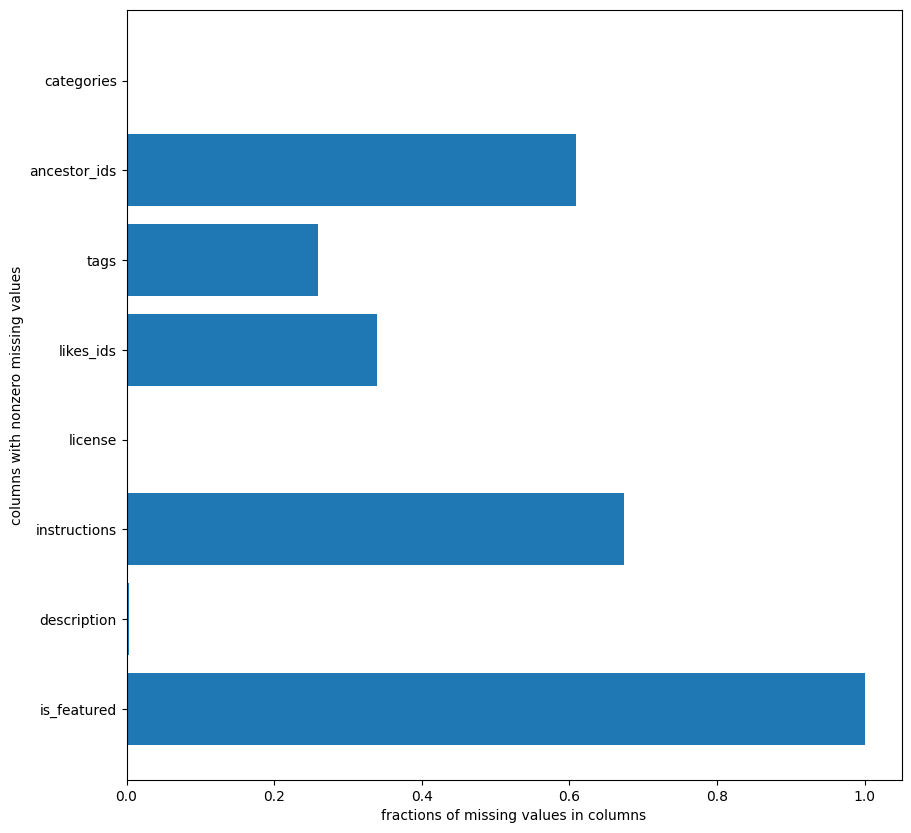

In [11]:
# quick exploration of mising values in target

fractions_missing = list(target_df.isnull().mean())
indexes_nonzero = [fractions_missing.index(ele) for ele in fractions_missing if ele >0]
fractions_missing_nonzero = [fractions_missing[i] for i in indexes_nonzero]

plt.barh(target_df.columns[indexes_nonzero], fractions_missing_nonzero)
plt.xlabel('fractions of missing values in columns')
plt.ylabel('columns with nonzero missing values')
plt.show()

The column is_featured is important to remove as it is uniformly null. Interestingly, the majority of instruction fields are null, perhaps due to migration of printing instructions to description. High null frequency in ancestors are not too surprising as many models aren't based on previous designs. With a full dataset we would have access to ancestor counts but that won't be possible with the partial dataset we have here. A large portion of the column likes_ids being null is probably due to zero likes on these models. We can capture this with like_count. So let's drop the columns is_featured, ancestor_ids, likes_ids.

In [12]:
reduced_df = target_df.drop(axis=1, columns = ["is_featured", "likes_ids", "ancestor_ids"])

## Potential independent variables to focus on

### categories

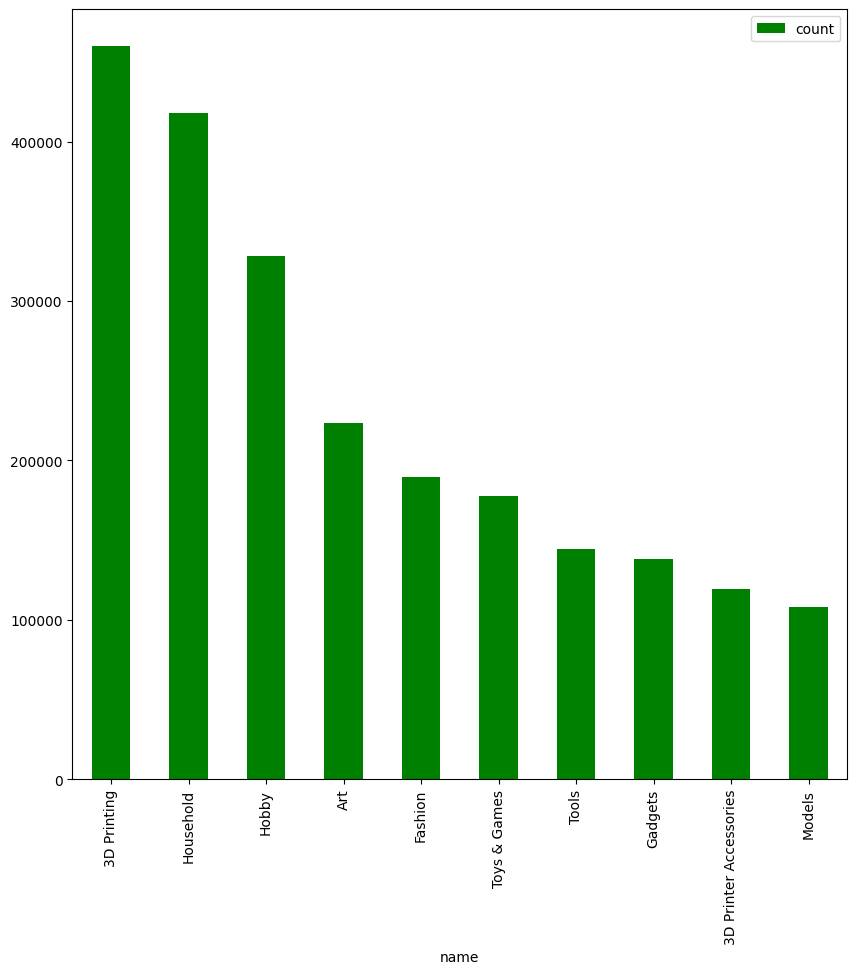

In [13]:
# category counts are independent of the sampling of things in the database (as long as it is sufficiently sampled)
sorted_categories = categories_df.sort_values('count', ascending=False)[:10]
sorted_categories.plot(x='name', y='count', kind='bar', color='g')

plt.show()

### tags

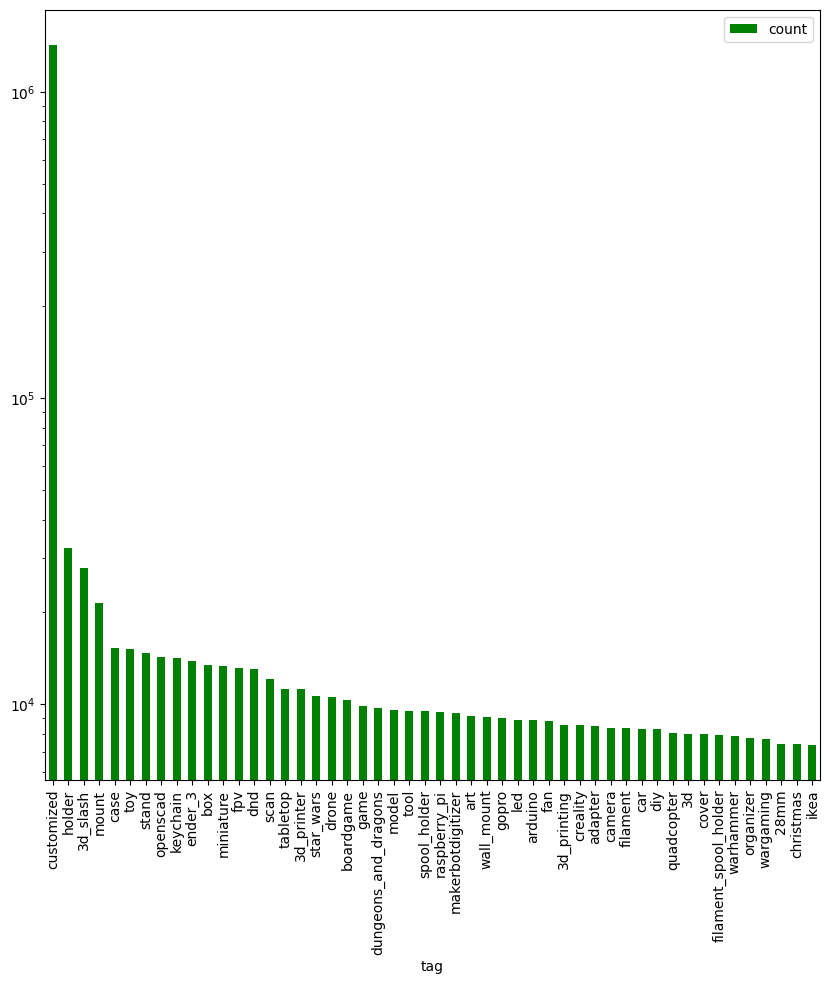

In [14]:
sorted_tags = tags_df.sort_values('count', ascending=False)[:50]
sorted_tags.plot(x='tag', y='count', kind='bar', logy=True, color='g')
plt.show()

Too high diversity, highly uniform except for general 
'customized' tag so unlikely to be too informative. 

### Files count

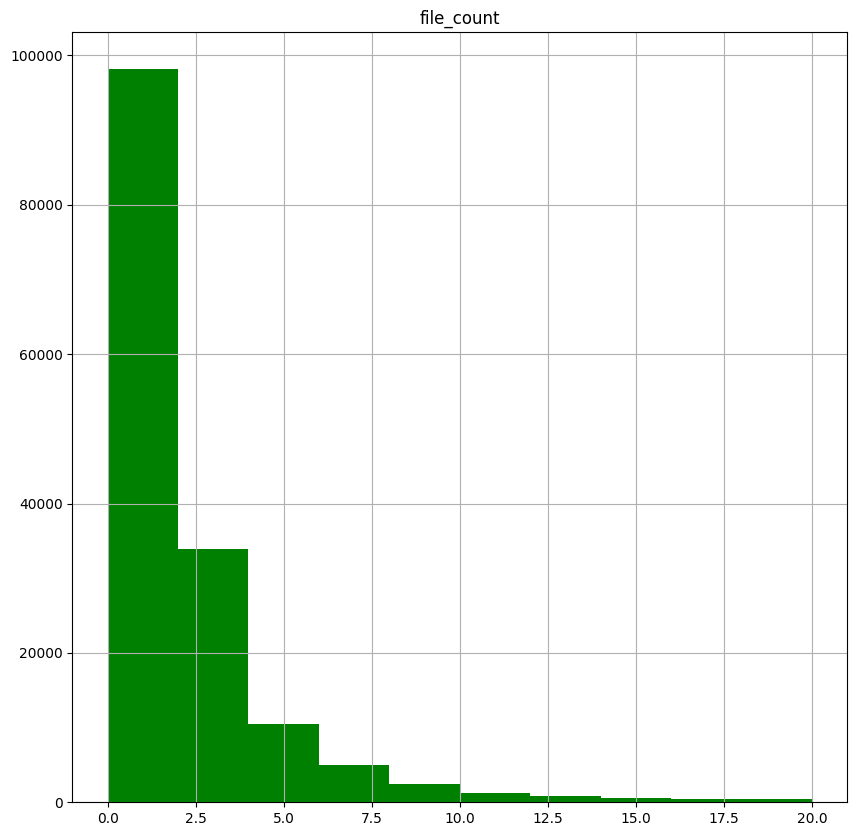

In [15]:
reduced_df.hist(column="file_count",bins=10, range = (0,20), color='g')
plt.show()

### Potential dependents

### like counts

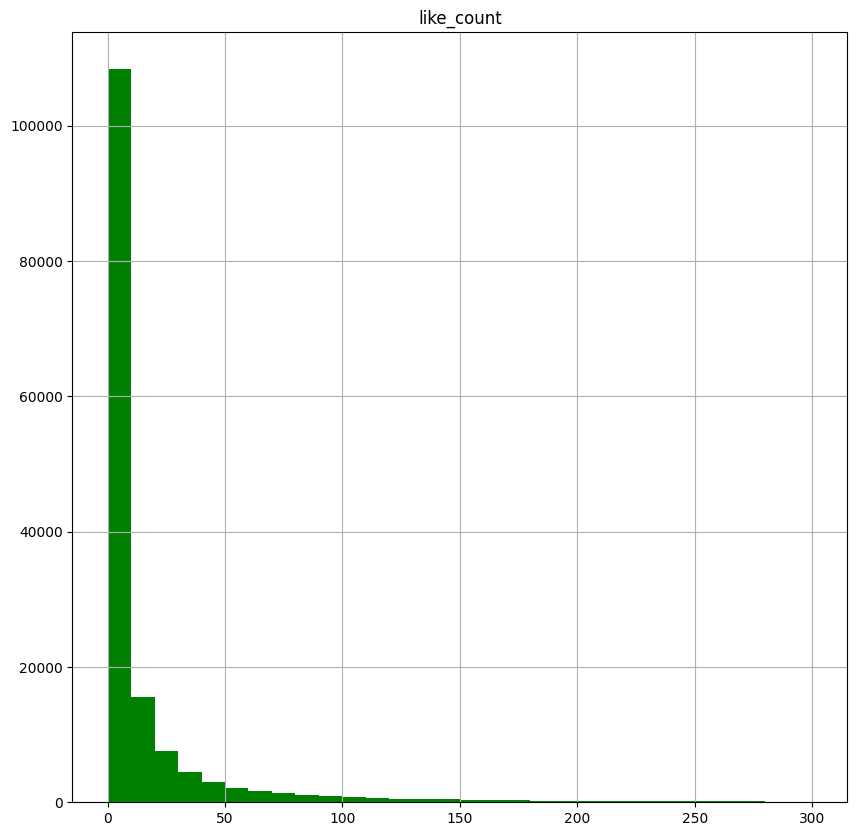

In [16]:
reduced_df.hist(column="like_count",bins=30, range=(0,300), color='g')
plt.show()

### downloads

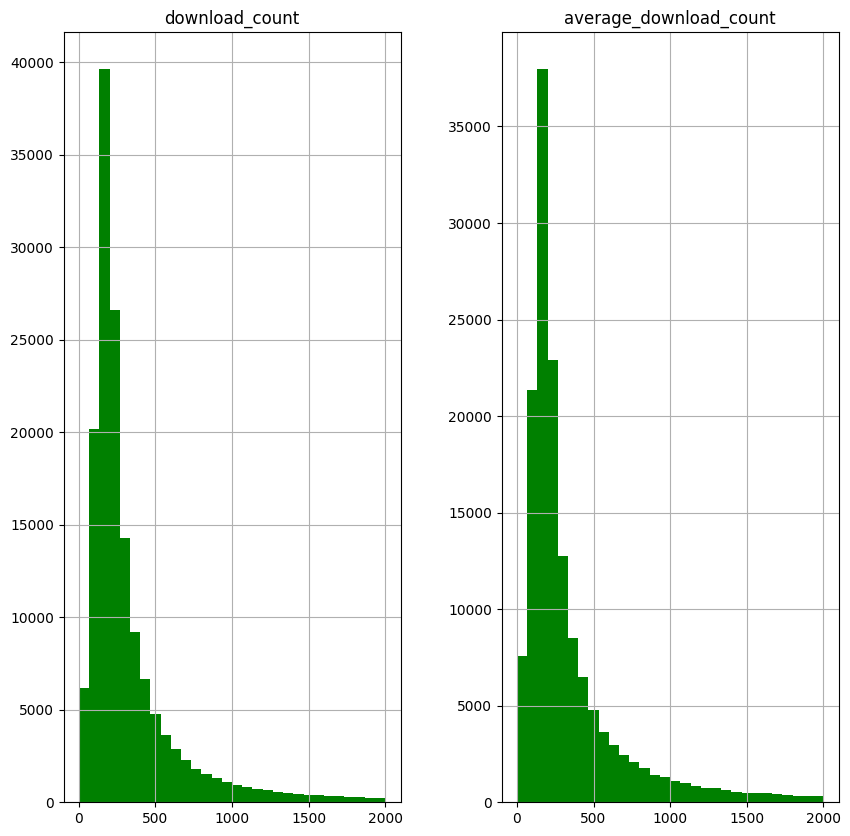

In [17]:
downloads = reduced_df[['download_count', 'average_download_count']]
downloads.hist(bins=30, range=(0,2000), color='g')
plt.show()

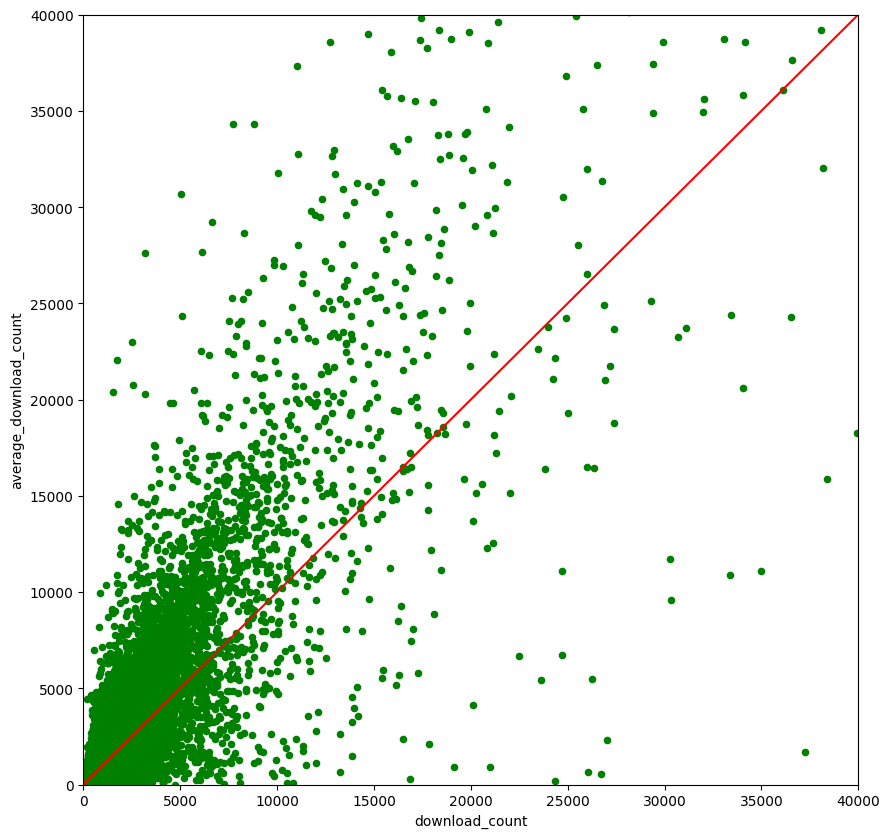

In [18]:
# average download count represents downloads averaged over all STL files per thingiverse post
reduced_df.plot(x="download_count", y="average_download_count",kind='scatter',c ='g')
plt.plot(range(0, 40000), range(0,40000), ls='-', color='red')
plt.xlim(0,40000)
plt.ylim(0,40000)
plt.show()

Apparent discrepancy between download count (explicit in the API), and the average number of downloads across STL files per post. Unclear what downloads actually represents (may be number of times "download all files" button was clicked).

How does the download metric vary as a function of time?

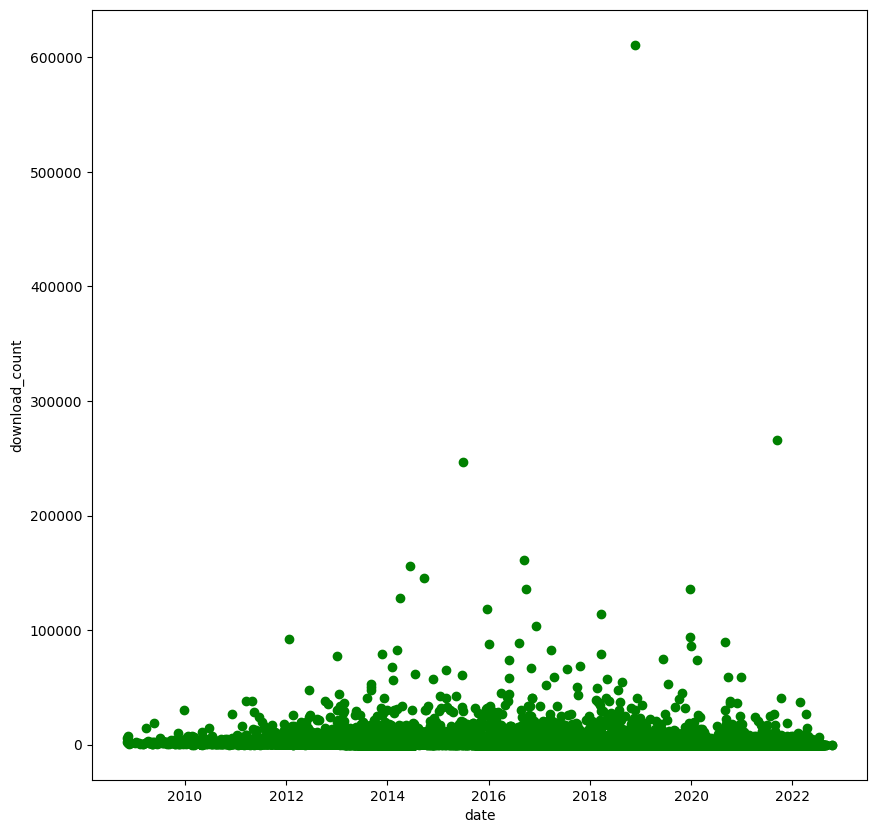

In [19]:
added_series = pd.to_datetime(reduced_df['added'])

plt.scatter(added_series, reduced_df['download_count'], c='g')
plt.xlabel('date')
plt.ylabel('download_count')
plt.show()

### view count

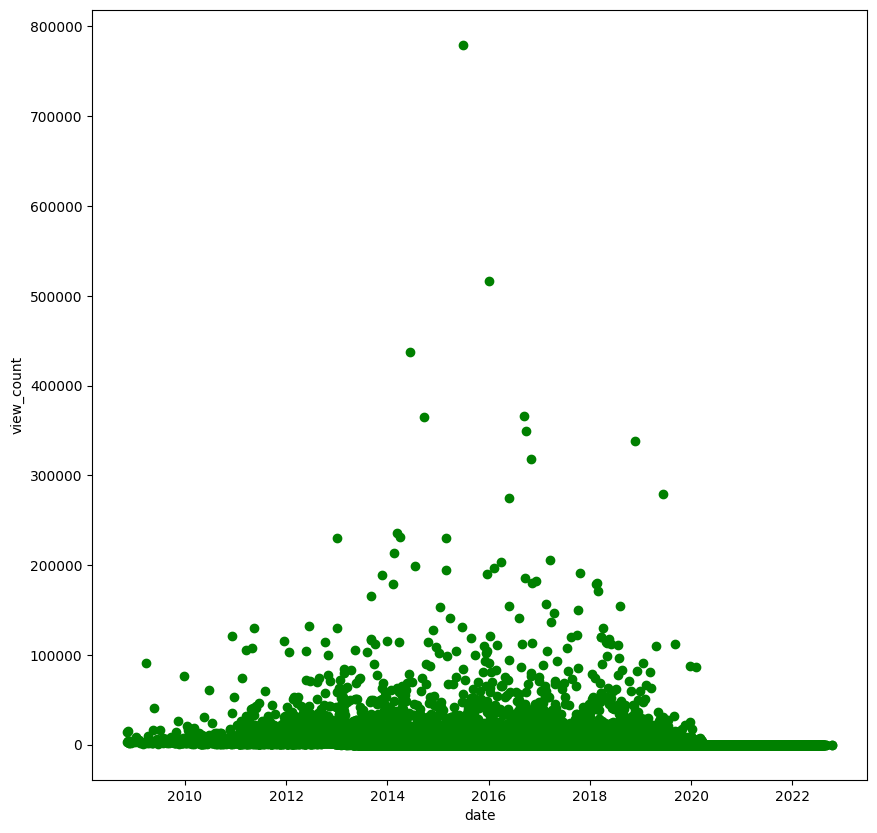

In [20]:
added_series = pd.to_datetime(reduced_df['added'])

plt.scatter(added_series, reduced_df['view_count'], c='g')
plt.xlabel('date')
plt.ylabel('view_count')
plt.show()

^ views suddenly disappear from 2020 onwards... limited predictive power for new posts and not useful to predictions in general with this truncation.

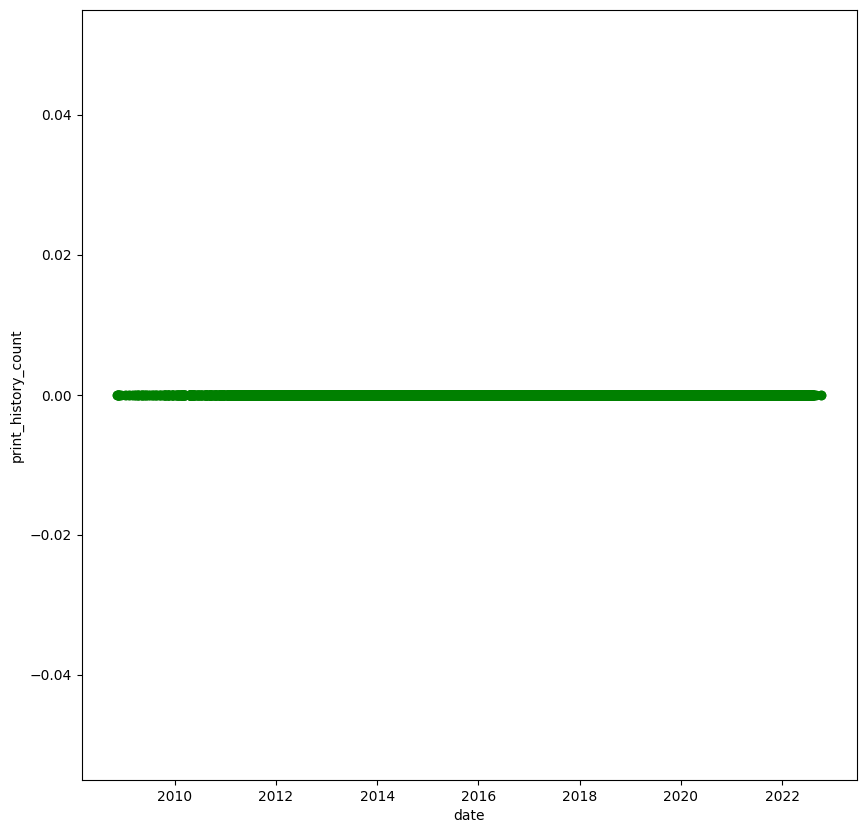

In [21]:
added_series = pd.to_datetime(reduced_df['added'])

plt.scatter(added_series, reduced_df['print_history_count'], c='g')
plt.xlabel('date')
plt.ylabel('print_history_count')
plt.show()

^clearly uninformative.

# Variance thresholding exploration for Bernoulli features:

In [22]:
from sklearn.feature_selection import VarianceThreshold

X_bernoulli = reduced_df[['is_wip', 'is_nsfw',
                  'allows_derivatives','is_derivative', 'can_comment']]

feat_sel = VarianceThreshold(0.6*(1-0.6))
feat_sel.fit(X_bernoulli)
X_bernoulli_new = X_bernoulli[X_bernoulli.columns[feat_sel.get_support(indices=True)]]

X_bernoulli_new.head()

,is_derivative
0,0
1,0
2,0
3,1
4,0


 ^ suggests I should remove all categorical features except is_derivative:

In [23]:
reduced_x2_df = reduced_df.drop(axis=1, columns = ["is_wip", "is_nsfw", "allows_derivatives", "can_comment"])

# Brief feature engineering/extraction

In addition to the engineering in the database code (db_utils.py - added_images_count is an example), one idea I have is that in addition to images, perhaps the length or verbosity of the descriptions is also useful. Images are intuitive, as you can see the results of printing a model, but how detailed the description is often acts as a hook for users. For this reason I will extract the length of both the instructions and descriptions cells:

In [24]:
len(target_df['description'][0])

def text_length(some_input):
    if some_input:
        return len(some_input)
    else:
        return 0

reduced_x2_df['desc_length'] = reduced_x2_df['description'].apply(lambda row:text_length(row))
reduced_x2_df['inst_length'] = reduced_x2_df['instructions'].apply(lambda row:text_length(row))

reduced_x2_df.head()

,thing_id,name,thumbnail,public_url,added,modified,like_count,collect_count,comment_count,description,...,added_images_count,average_download_count,tags,creator_id,accessed,categories,count_of_followers,count_of_designs,desc_length,inst_length
0,3700502,Canon 100mm F2.8 focus gear,https://cdn.thingiverse.com/renders/58/26/5b/3...,https://www.thingiverse.com/thing:3700502,2019-06-19T08:08:19+00:00,2019-06-19T08:08:19+00:00,4,10,0,I love focus pullers but i hate those adjustab...,...,-1,329,"[""100mm"", ""3mm"", ""canon"", ""f28"", ""focus"", ""gea...",1781133,2022-08-19T17:35:35+00:00,"[""Camera""]",1,4,626,0
1,2835030,Bumpy coin,https://cdn.thingiverse.com/renders/ab/6c/25/a...,https://www.thingiverse.com/thing:2835030,2018-03-21T19:31:29+00:00,2018-03-21T19:31:29+00:00,0,0,0,This thing was made with Tinkercad. Edit it on...,...,0,168,None,1838357,2022-08-19T17:35:41+00:00,"[""3D Printing""]",0,5,95,0
2,428667,Replacement clip for kids diving mask,https://cdn.thingiverse.com/renders/8a/1e/56/2...,https://www.thingiverse.com/thing:428667,2014-08-14T20:59:47+00:00,2014-08-14T20:59:47+00:00,19,33,0,I hate this throw-away world so when the clip ...,...,0,491,"[""mask"", ""openscad"", ""replacement"", ""replaceme...",16829,2022-08-19T17:35:48+00:00,"[""Replacement Parts""]",107,112,226,189
3,67583,Rabbit Nose (clip-on),https://cdn.thingiverse.com/assets/87/21/31/65...,https://www.thingiverse.com/thing:67583,2013-03-29T22:48:10+00:00,2013-03-29T22:48:10+00:00,668,859,10,"I made up this little ""clip-on"" rabbit nose fo...",...,1,5680,"[""bunny"", ""bunny_toy"", ""easter"", ""fun"", ""hallo...",16829,2022-08-20T15:40:36+00:00,"[""Accessories""]",107,112,142,395
4,17608,Welslo 10.5 Treadmill Storage Latch,https://cdn.thingiverse.com/renders/cd/93/d4/9...,https://www.thingiverse.com/thing:17608,2012-02-14T20:05:12+00:00,2012-02-14T20:05:12+00:00,3,6,0,This is part #120 from WLTL98761 - It may fit ...,...,1,706,"[""replacement_part""]",16829,2022-08-28T03:40:54+00:00,"[""Other""]",107,112,237,55


# Download count estimation with pared down thing features

Let's see what features are left after our variance thresholding and null column elimination above:

In [25]:
reduced_x2_df.columns

Index(['thing_id', 'name', 'thumbnail', 'public_url', 'added', 'modified',
       'like_count', 'collect_count', 'comment_count', 'description',
       'instructions', 'details', 'license', 'file_count',
       'print_history_count', 'download_count', 'view_count', 'remix_count',
       'make_count', 'root_comment_count', 'is_derivative',
       'added_images_count', 'average_download_count', 'tags', 'creator_id',
       'accessed', 'categories', 'count_of_followers', 'count_of_designs',
       'desc_length', 'inst_length'],
      dtype='object')

We can remove non-categorical or non-enumerable features like names, urls, details (seemingly unused) and then consider the transformation of categorical features like 'categories' into a format that can be accepted by regression models:

In [26]:
selected_features = ['like_count', 'collect_count',
                  'comment_count', 'desc_length', 
                     'inst_length', 'file_count', 
                  'remix_count','make_count',
                 'root_comment_count', 'is_derivative',
                 'added_images_count', 'count_of_followers',
                    'count_of_designs']

In [27]:
# convert top 10 category features to one-hot representation
top_10_categories = list(sorted_categories['name'].iloc[0:10])
only_categories_df = reduced_x2_df[['categories']].fillna('["Other"]')#.apply(lambda x:json.loads(x)[0])

# first convert list of single categories to string of category
only_categories_df['categories'] = only_categories_df['categories'].apply(lambda x:json.loads(x)[0])

# fit and transform this column of strings using onehotencoder 
encoder = OneHotEncoder(handle_unknown='ignore', categories=[top_10_categories])

encoder_df = pd.DataFrame(encoder.fit_transform(only_categories_df[['categories']]).toarray())
encoder_df.columns = ["cat:" + ele for ele in top_10_categories]

# join original table and encoder_df (joins on index by default)
reduced_x2_inccat_df = reduced_x2_df.join(encoder_df, how='left').drop('categories', axis=1)

#create final dataframe
selected_features.extend(list(encoder_df.columns))
y_df = reduced_x2_inccat_df['download_count']
x_df = reduced_x2_inccat_df[selected_features]

x_df.head()

,like_count,collect_count,comment_count,desc_length,inst_length,file_count,remix_count,make_count,root_comment_count,is_derivative,...,cat:3D Printing,cat:Household,cat:Hobby,cat:Art,cat:Fashion,cat:Toys & Games,cat:Tools,cat:Gadgets,cat:3D Printer Accessories,cat:Models
0,4,10,0,626,0,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,95,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19,33,0,226,189,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,668,859,10,142,395,3,1,8,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,6,0,237,55,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature importance from a Random Forest model of download count

## Hyperparameter grid-search to first construct a reasonable RFR model

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size= 0.25, random_state = 12)
#cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state= 42)

rf_grid = RandomForestRegressor()

param_grid = {'min_samples_split': [6, 8, 10, 12],
              'n_estimators': [150, 200, 250],
              'max_depth': [10, 12, 14],
              'max_features': ['sqrt', 'log2']}

grid_search = GridSearchCV(rf_grid, param_grid, scoring='r2', 
                            return_train_score=True, n_jobs = -1)

grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [6, 8, 10, 12],
                         'n_estimators': [150, 200, 250]},
             return_train_score=True, scoring='r2')

In [36]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'n_estimators': 250}

In [37]:
rf = RandomForestRegressor(**grid_search.best_params_)

rf.fit(x_train, y_train)
print(rf.score(x_train,y_train))

0.7569510036151574


In [38]:
print(rf.score(x_test,y_test))

0.7616263022720745


## Explained variance based feature importance

Text(0.5, 0, 'Random Forest Feature Importance (reduction in variance in regression)')

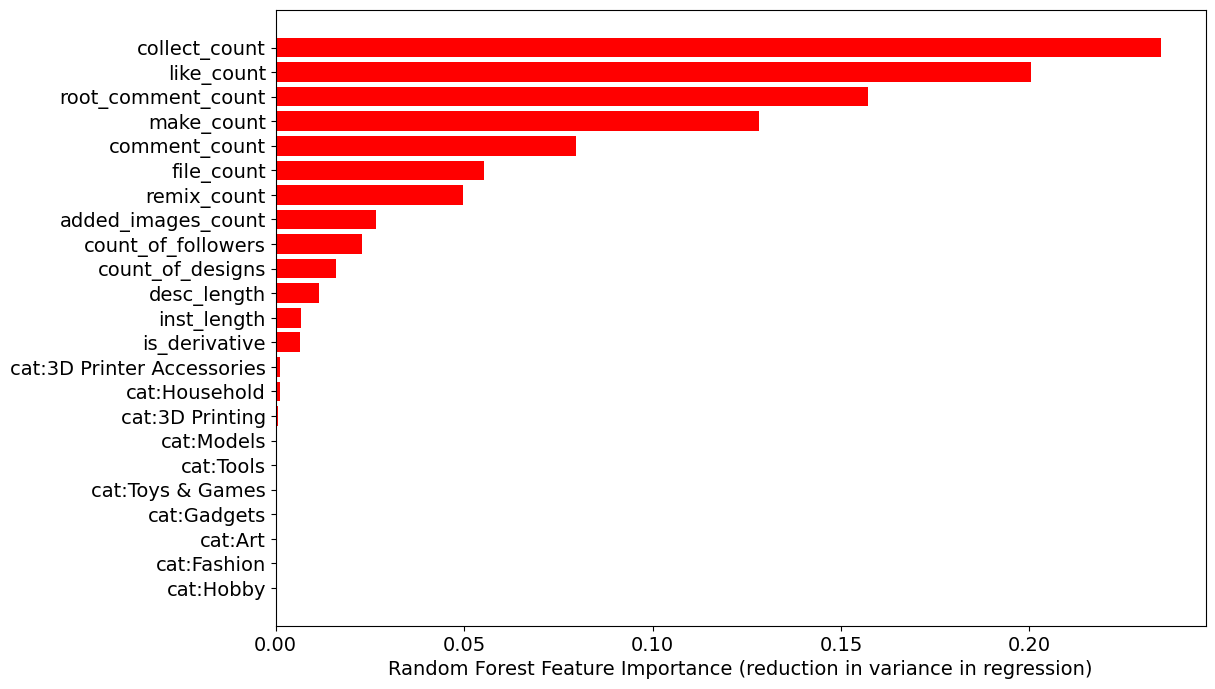

In [40]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})
sorted_indexes_variance = rf.feature_importances_.argsort() #MSE importance
plt.barh(x_train.columns[sorted_indexes_variance], rf.feature_importances_[sorted_indexes_variance], color='red')
plt.xlabel("Random Forest Feature Importance (reduction in variance in regression)")

^ Note that high cardinality (numerical) features will generally have higher feature importance by this measure (model ends up constructing a mapping between X and Y, where X is high variance). We can address this potential issue with permutation importance below.

## Permutation importance

Text(0.5, 0, 'Permutation Importance (training set)')

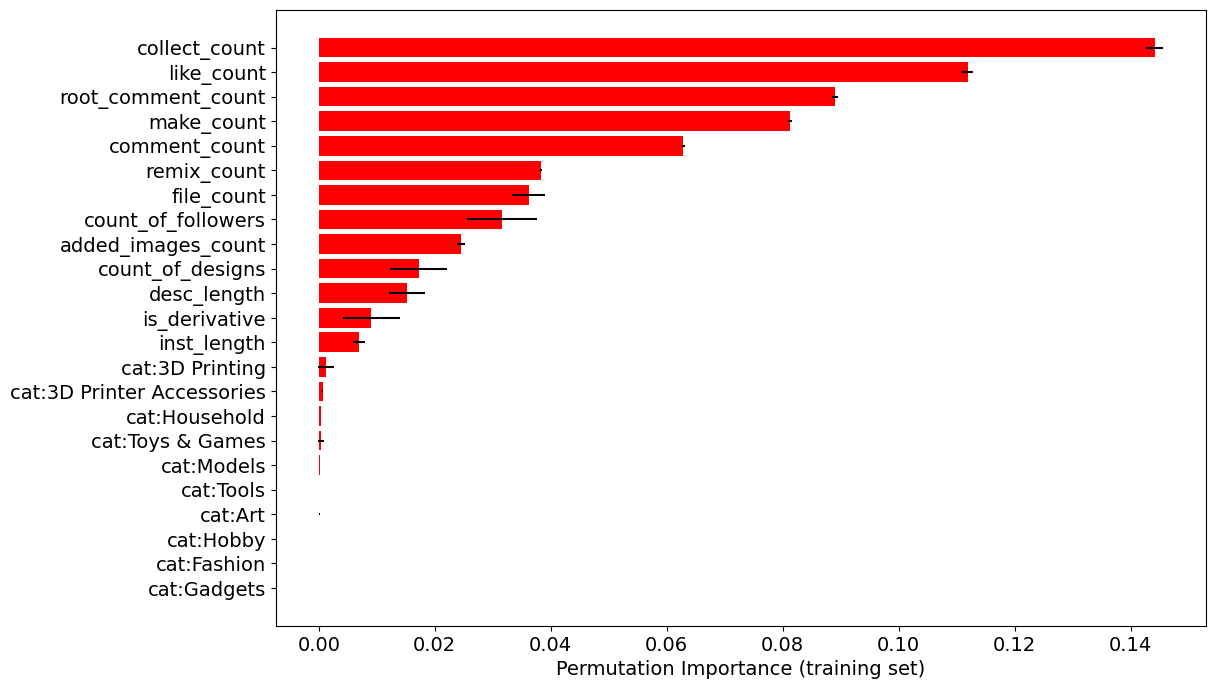

In [45]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, x_train, y_train, n_repeats=8, n_jobs=-1)

sorted_indexes_perm = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_indexes_perm], perm_importance.importances_mean[sorted_indexes_perm],
         xerr= perm_importance.importances_std[sorted_indexes_perm], color='red')
plt.xlabel("Permutation Importance (training set)")

^ Interesting to see some congruence with the variance based feature importance above. So what can we say to new users interested in posting a popular model? In terms of parameters they can change, across both methods this analysis  suggests in the same order of importance: (1) Increasing the number of individual files for download (likely modifications to the same model), (2) Increasing the number of added images of prints of the models, and (3) Being more verbose in the model description and/or printing instructions. Note that with root_comment_count and comment_count, the direction of causality has to be treated carefully, but could indicate that increased interaction with users increases the probability a model is downloaded.